# Vehicle Detection
**Igor Passchier**

**igor.passchier@tassinternational.com**

## Helper functions

In [1]:
%matplotlib inline


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
import sklearn.svm as svm
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label




In [222]:
#Functions to plot multiple images, side by side
#imgs: array of images to plot
#titles: array of titles
#cmaps: array of color maps to use. For historic reasons, if a cmap is True, the image will be plotted in greyscale
def plot_multi(imgs,titles=None,cmaps=None):
    count=len(imgs)
    f,ax=plt.subplots(1,count,figsize=(10*count,10))
    for i in range(count):
        axis=ax[i]
        if(cmaps is not None and len(cmaps)>i ):
            if (cmaps[i] is True):
                axis.imshow(imgs[i],cmap='gray')
            elif (cmaps[i] is False):
                axis.imshow(imgs[i])
            else:
                axis.imshow(imgs[i],cmap=cmaps[i])
        else:
            axis.imshow(imgs[i])

        if(titles is not None and len(titles)>i and titles[i] is not None):
            axis.set_title(titles[i])
    plt.show()
    
    
#Plot 2 images next to each other
def plot2(img1,img2,title1=None,title2=None,grey1=False,grey2=False):
    plot_multi((img1,img2),(title1,title2),(grey1,grey2))
    


## Create training data file names

In [3]:
# create test image file names. Every file matching the regex is included. If 'non-vehicles'
# is in the file name, it is assume to be not a vehicle. Otherwise, it is assumed to be a vehicle
def create_testimages_filenames(regex='training_data/*/*/*.png', max_samples=None,shuffle=True):
    images = glob.glob(regex)
    cars = []
    notcars = []
    for image in images:
        if 'non-vehicles' in image :
            notcars.append(image)
        else:
            cars.append(image)

    # Reduce the sample size 
    if (shuffle):
        random.shuffle(cars)
        random.shuffle(notcars)
        
    if (not (max_samples is None)):
        cars = cars[0:max_samples]
        notcars = notcars[0:max_samples]
    
    return cars,notcars

def read_image(file):
    image = mpimg.imread(file)
    # scale 0-1 to 0-255 for png images read by mpimg
    if '.png' in file:
        image =(image * 255).astype(np.uint8)
    return image

In [4]:
cars,notcars=create_testimages_filenames()
print ('***********', len(cars) , ' cars, and ', len(notcars), ' not cars loaded')


*********** 8792  cars, and  8968  not cars loaded


## Hog features extraction

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



#####HOG from grayscale


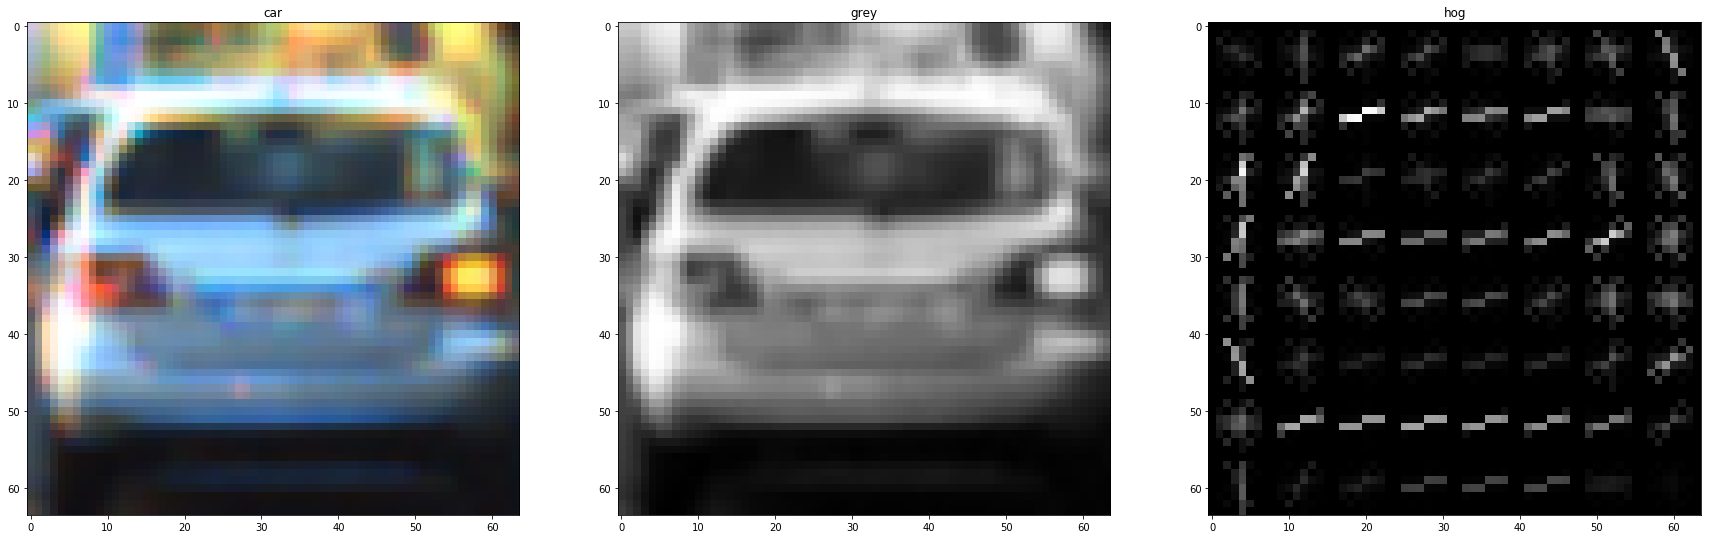

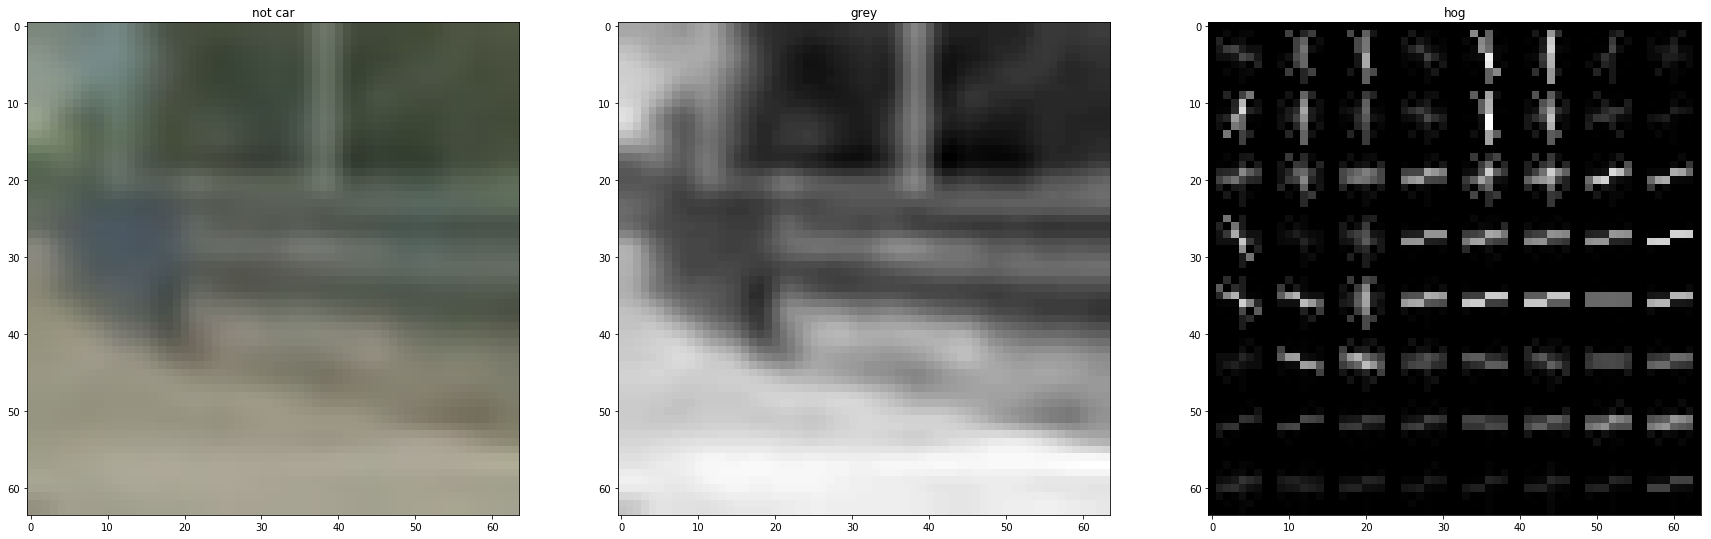

#####HOG from Y of YCrCb


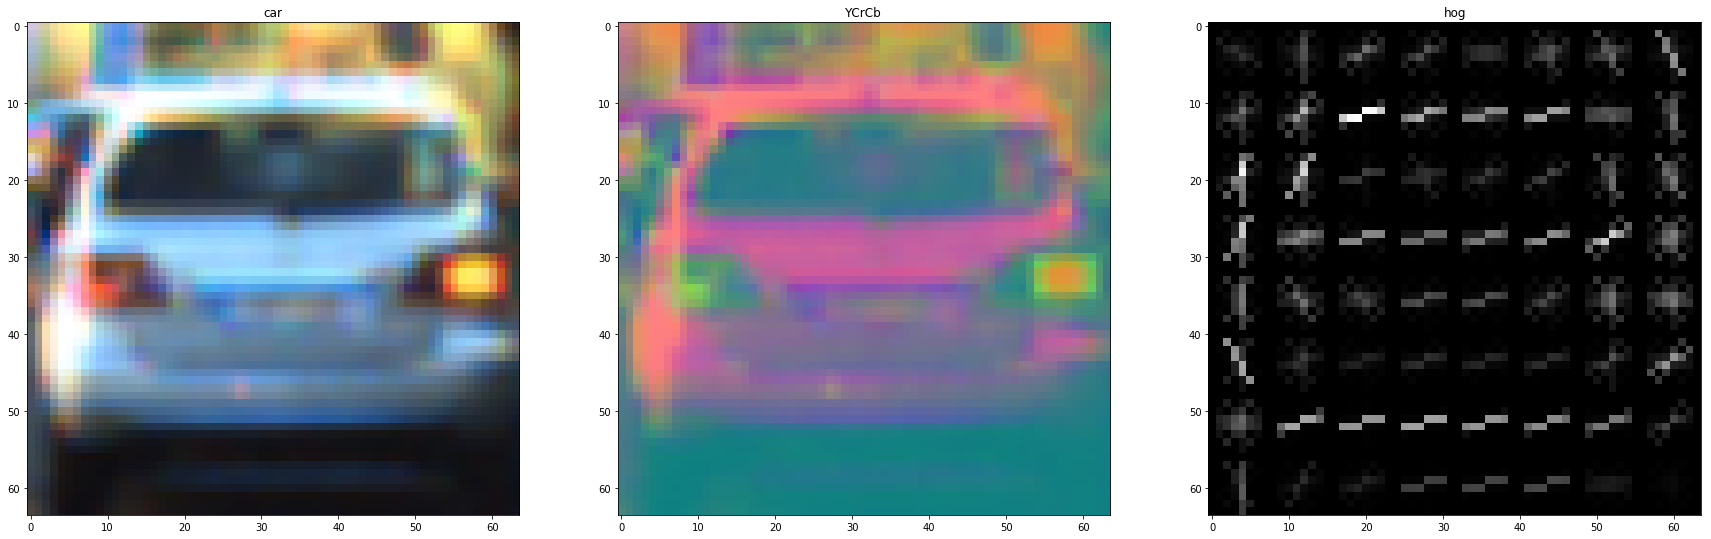

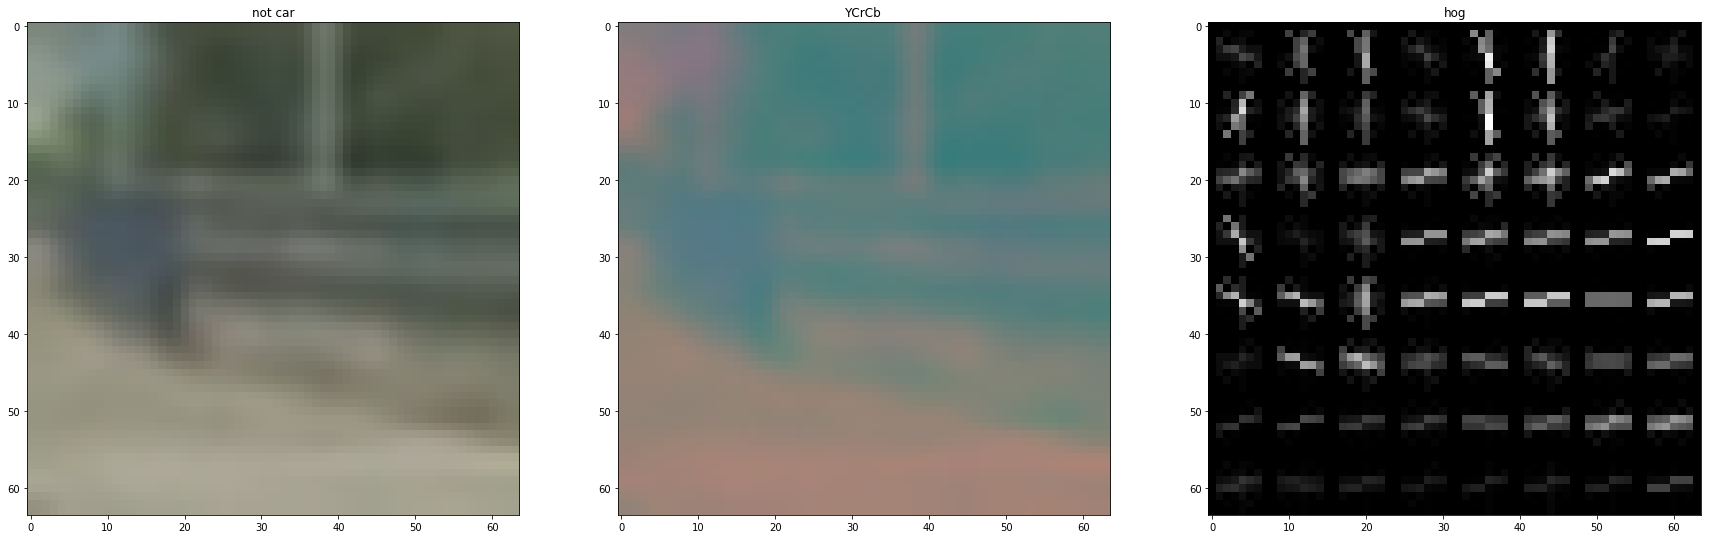

In [303]:
#test hog features
car=read_image(cars[4])
no=read_image(notcars[1])


gcar = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
(features,hcar)=get_hog_features(gcar,9,8,2,True,False)

gno = cv2.cvtColor(no, cv2.COLOR_RGB2GRAY)
(features,hno)=get_hog_features(gno,9,8,2,True,True)


ycar = cv2.cvtColor(car, cv2.COLOR_RGB2YCrCb)
(features,hycar)=get_hog_features(ycar[:,:,0],9,8,2,True,False)

yno = cv2.cvtColor(no, cv2.COLOR_RGB2YCrCb)
(features,hyno)=get_hog_features(yno[:,:,0],9,8,2,True,True)



print("#####HOG from grayscale")
plot_multi((car,gcar,hcar),('car','grey','hog'),(False,True, True))
plot_multi((no,gno,hno),('not car','grey','hog'),(False,True, True))

print("#####HOG from Y of YCrCb")
plot_multi((car,ycar,hycar),('car','YCrCb','hog'),(False,True, True))
plot_multi((no,yno,hyno),('not car','YCrCb','hog'),(False,True, True))



## Spatial binning

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

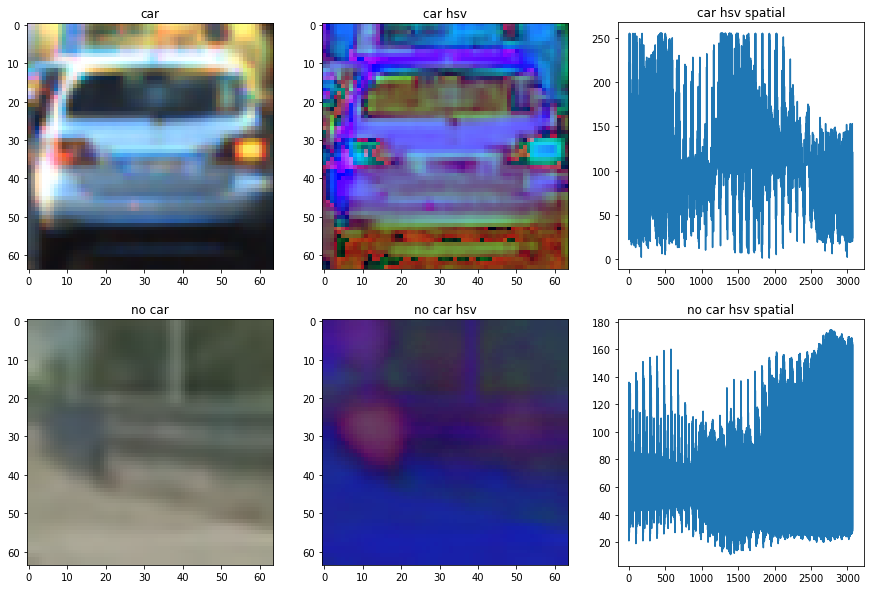

In [308]:
#test spatial color binning
imgcar=read_image(cars[4])
imgcarhsv = cv2.cvtColor(imgcar, cv2.COLOR_RGB2HSV)
histcar=bin_spatial(imgcarhsv)

imgnot=read_image(notcars[1])
imgnothsv = cv2.cvtColor(imgnot, cv2.COLOR_RGB2HSV)
histnot=bin_spatial(imgnothsv)

f,ax=plt.subplots(2,3,figsize=(15,10))
ax[0,0].imshow(imgcar)
ax[0,1].imshow(imgcarhsv)
ax[0,2].plot(histcar)
ax[1,0].imshow(imgnot)
ax[1,1].imshow(imgnothsv)
ax[1,2].plot(histnot)

ax[0,0].set_title('car')
ax[0,1].set_title('car hsv')
ax[0,2].set_title('car hsv spatial')
ax[1,0].set_title('no car')
ax[1,1].set_title('no car hsv')
ax[1,2].set_title('no car hsv spatial')


plt.show()

## Color histogramming

In [7]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

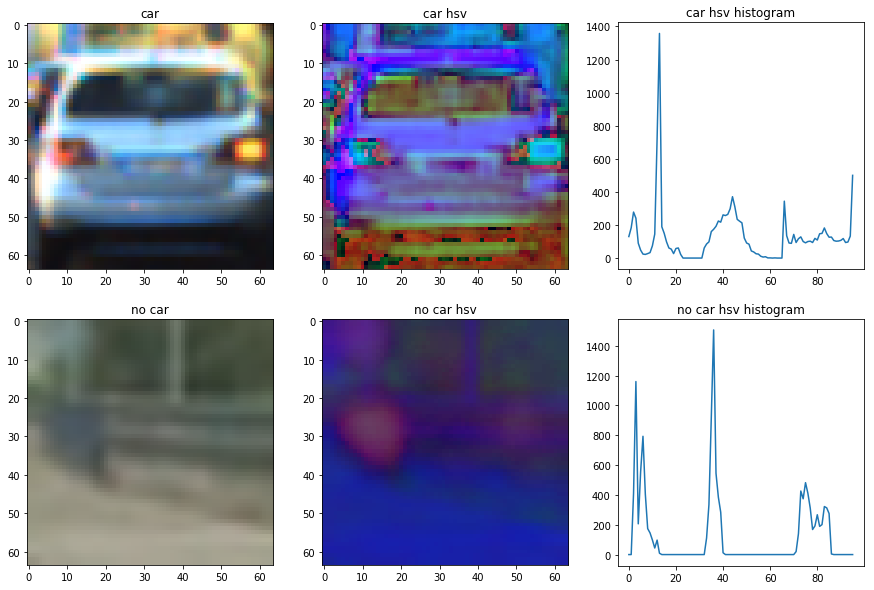

In [310]:
# test color histogramming
imgcar=read_image(cars[4])
imgcarhsv = cv2.cvtColor(imgcar, cv2.COLOR_RGB2HSV)
histcar=color_hist(imgcarhsv)

imgnot=read_image(notcars[1])
imgnothsv = cv2.cvtColor(imgnot, cv2.COLOR_RGB2HSV)
histnot=color_hist(imgnothsv)

f,ax=plt.subplots(2,3,figsize=(15,10))
ax[0,0].imshow(imgcar)
ax[0,1].imshow(imgcarhsv)
ax[0,2].plot(histcar)
ax[1,0].imshow(imgnot)
ax[1,1].imshow(imgnothsv)
ax[1,2].plot(histnot)

ax[0,0].set_title('car')
ax[0,1].set_title('car hsv')
ax[0,2].set_title('car hsv histogram')
ax[1,0].set_title('no car')
ax[1,1].set_title('no car hsv')
ax[1,2].set_title('no car hsv histogram')


plt.show()

## Feature extraction
The functions below extracts all features from a single image and from a set of images on disk. 

In [244]:
# Define a function to extract features from a single image window
# The last 3 parameters determine what features are included: spatial, color histogram, and hog
def single_img_features(img, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    file_features = np.empty(0)
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)    

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features=np.append(file_features,spatial_features)

    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features=np.append(file_features,hist_features)

    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            #always do HOG in YCrCb
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features=np.append(file_features,hog_features)
    
    return file_features.ravel()

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = read_image(file)
        file_features=single_img_features(image,color_space,spatial_size,hist_bins,orient,
                                          pix_per_cell,cell_per_block, hog_channel,
                                          spatial_feat,hist_feat,hog_feat)
        features.append(file_features)

    # Return list of feature vectors
    return features

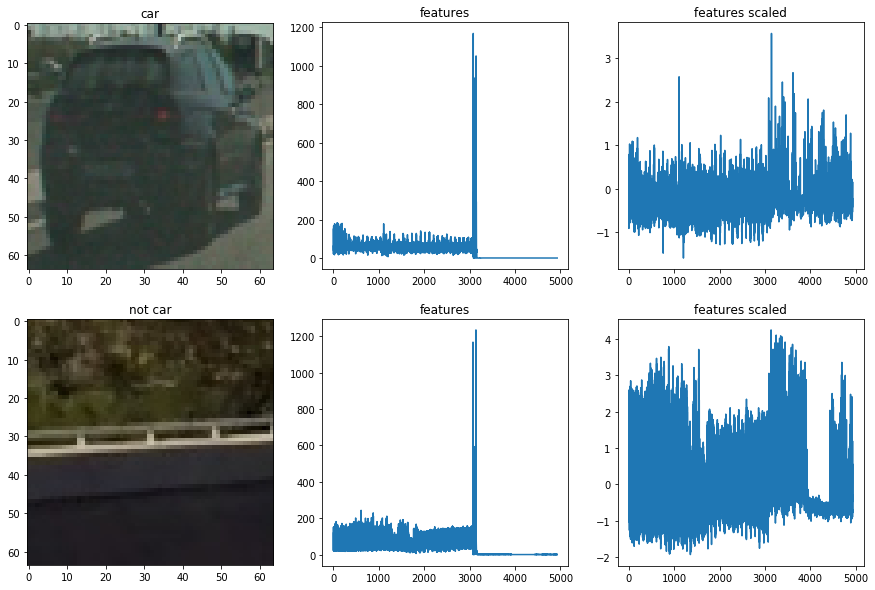

In [259]:
spatial=True
hist=True
hogs=True
(cars,not_cars)=create_testimages_filenames(max_samples=10)
car_features=extract_features(cars,spatial_feat=spatial, hist_feat=hist,hog_feat=hogs)
not_car_features=extract_features(not_cars,spatial_feat=spatial, hist_feat=hist,hog_feat=hogs)

X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

f,ax=plt.subplots(2,3,figsize=(15,10))
ax[0,0].imshow(read_image(cars[0]))
ax[0,1].plot(X[0])
ax[0,2].plot(scaled_X[0])
ax[1,0].imshow(read_image(not_cars[-1]))
ax[1,1].plot(X[-1])
ax[1,2].plot(scaled_X[-1])


ax[0,0].set_title('car')
ax[0,1].set_title('features')
ax[0,2].set_title('features scaled')
ax[1,0].set_title('not car')
ax[1,1].set_title('features')
ax[1,2].set_title('features scaled')
plt.show()

## Create training data

In [260]:
#Read and process the training data.

colorspace = 'YUV' 
orient = 11 
pix_per_cell = 16 
cell_per_block = 2
hog_channel = "ALL"

#color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [490, 720] # Min and max in y to search in slide_window()

cars,notcars=create_testimages_filenames()
print ('***********', len(cars) , ' cars, and ', len(notcars), ' not cars loaded')


t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

t2 = time.time()
print('Spatial features: ',spatial_feat)
print('Historgram features: ',hist_feat)
print('Hog features: ',hog_feat)

print('Feature vector length:', len(X_train[0]))
print('Feature extraction took ',round(t2-t,2),' seconds')


*********** 8792  cars, and  8968  not cars loaded
Spatial features:  True
Historgram features:  True
Hog features:  True
Feature vector length: 2004
Feature extraction took  96.9  seconds


## Train the model

In [242]:
#Train the model

parameters = {'kernel':['rbf'], 'C':[10], 'gamma':[0.0005]}
#default for gamma is 1/n_features. Fit resulted also in 1/n_features, with rbf and C=10
svr = svm.SVC()
svc = model_selection.GridSearchCV(svr, parameters)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Feature vector length:', len(X_train[0]))
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
svc.best_params_

Feature vector length: 2004
225.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9977


In [14]:
svc.best_params_

{'C': 10, 'gamma': 0.0005, 'kernel': 'rbf'}

In [262]:
#Extract features from an image, and run the classification on it
def classify_image(img, clf, scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat):
    
    features = single_img_features(img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    test_features = scaler.transform(np.array(features).reshape(1, -1))
    prediction = clf.predict(test_features)
    return prediction


### Inspect incorrectly classified test images

Incorrectly classified cars


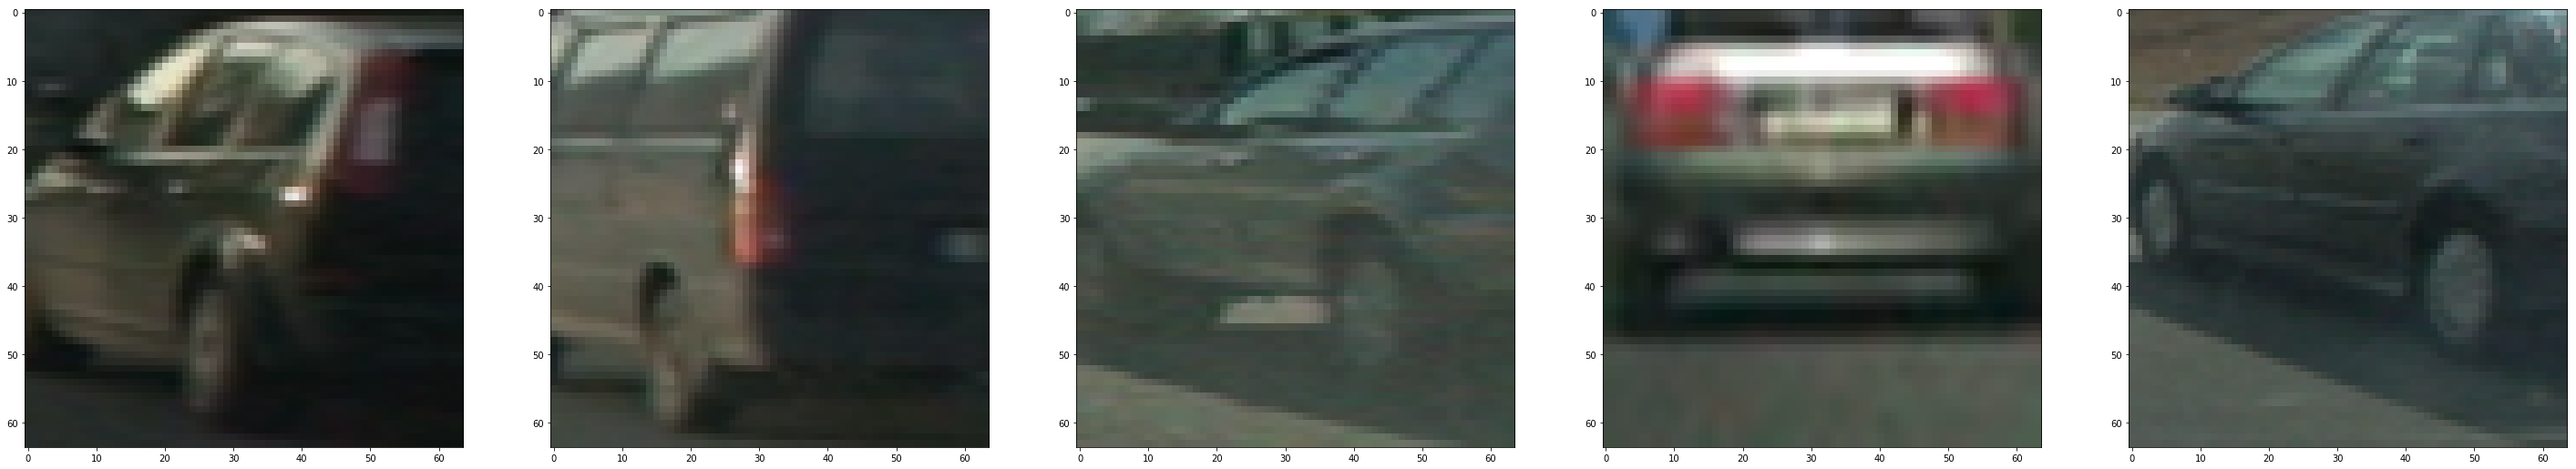

Incorrectly classified non-cars


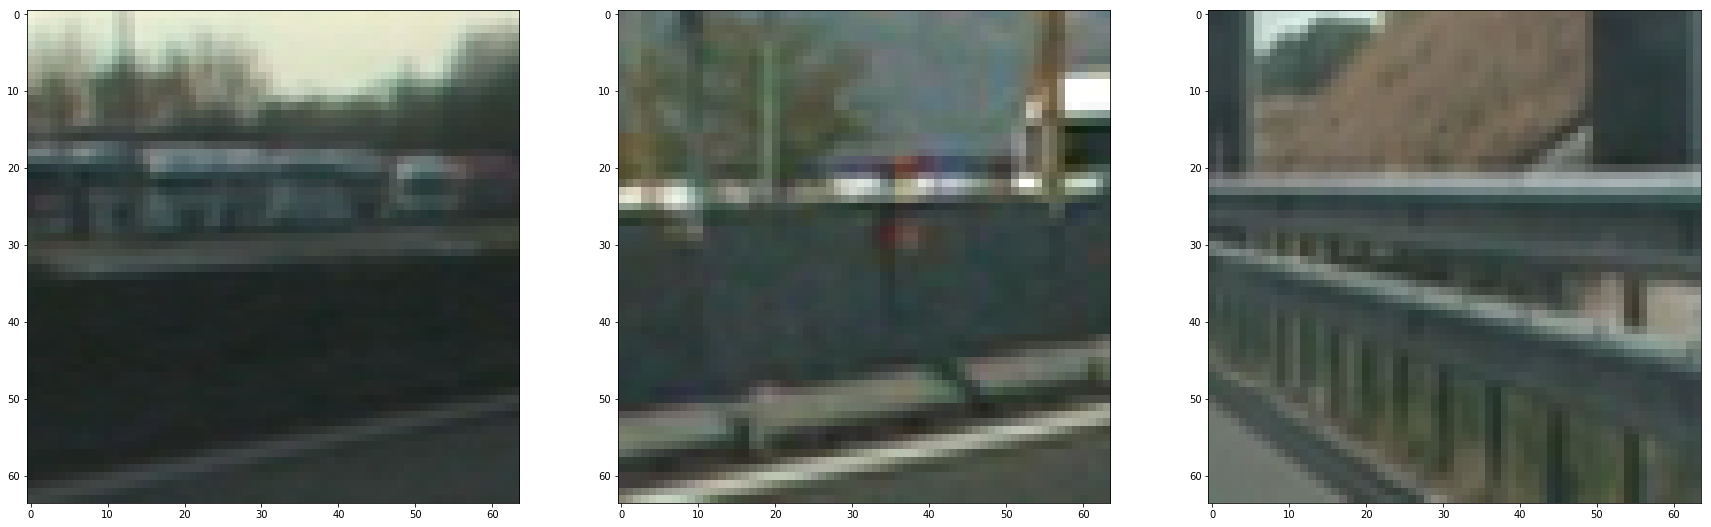

In [245]:
wrongs=[]
for img in cars:
    img=read_image(img)
    p=classify_image(img,svc,X_scaler,color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    if (p<1):
        wrongs.append(img)
    if (len(wrongs)>=10):
        break
print("Incorrectly classified cars")
plot_multi(wrongs,[],[])

wrongs=[]
for img in notcars:
    img=read_image(img)
    p=classify_image(img,svc,X_scaler,color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    if (p>0):
        wrongs.append(img)
    if (len(wrongs)>=10):
        break
print("Incorrectly classified non-cars")
plot_multi(wrongs,[],[])

## Functions to scan through an image for cars

### Define the windows to use in the search

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#Function to create all windows. The function creates windows in 3 sizes, covering the relevant
#area of the image for every size seperately
def create_windows(shape,small=True,medium=True,large=True,overlap=0.5):
    windows=[]

    if (small):
        w = slide_window(shape, x_start_stop=[200, 1050], y_start_stop=[400,500], 
                        xy_window=(32, 32), xy_overlap=(overlap, overlap))
        for win in w:
            windows.append(win)
    if (medium):
        w = slide_window(shape, x_start_stop=[0, 1280], y_start_stop=[350,650], 
                        xy_window=(96, 96), xy_overlap=(overlap, overlap))
        for win in w:
            windows.append(win)

    if (large):
        w = slide_window(shape, x_start_stop=[48, None], y_start_stop=[350,700], 
                        xy_window=(192, 192), xy_overlap=(overlap, overlap))
        for win in w:
            windows.append(win)


    return windows

### Utility function to draw bounding boxes on an image

In [17]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color is None:
            c=(np.random.randint(0, 255),np.random.randint(0, 255),np.random.randint(0, 255))
        else:
            c=color
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], c, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Test and create final windows

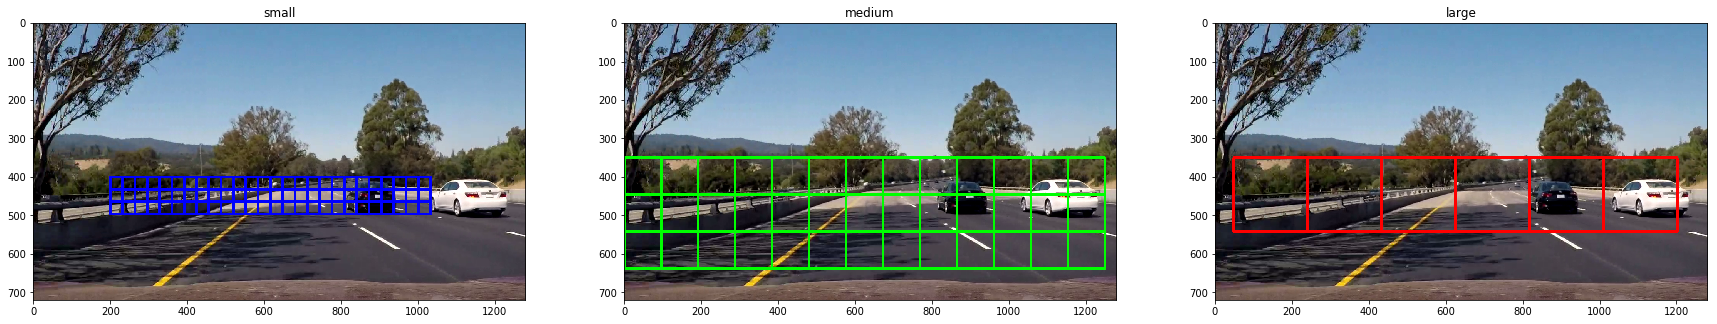

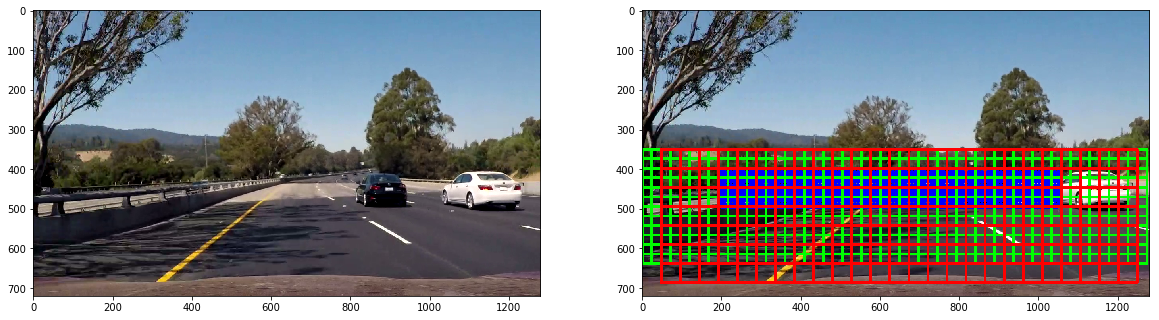

In [274]:
image=read_image('snap3.png')

draw_image = np.copy(image)

overlap=0

wsmall=create_windows(image.shape,True,False,False,overlap)
w1 = draw_boxes(draw_image, wsmall, color=(0,0,255), thick=6)

wmed=create_windows(image.shape,False,True,False,overlap)
w2 = draw_boxes(draw_image, wmed, color=(0,255,0), thick=6)

wlarge=create_windows(image.shape,False,False,True,overlap)
w3 = draw_boxes(draw_image, wlarge, color=(255,0,0), thick=6)

plot_multi([w1,w2,w3],["small","medium","large"])

overlap=0.75
windows=create_windows(image.shape,True,True,False,overlap=overlap)


wsmall=create_windows(image.shape,True,False,False,overlap)
wmed=create_windows(image.shape,False,True,False,overlap)
wlarge=create_windows(image.shape,False,False,True,overlap)
out = draw_boxes(image, wsmall, color=(0,0,255), thick=6)
out = draw_boxes(out, wmed, color=(0,255,0), thick=6)
out = draw_boxes(out, wlarge, color=(255,0,0), thick=6)


plot_multi([image,out])

### Perform the search in all defined windows
This function is not optimized for speed, and is not used in the final pipeline

In [16]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat):

    #1) Create an empty list to receive positive detection windows
    hot = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            hot.append(window)
    #8) Return windows for positive detections
    return hot
    

In [276]:
#search a single image and return all hot windows
def search_one(image,plot=False):
    t=time.time()

    
    hot = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    t2=time.time()
    if (plot):
        window_img = draw_boxes(image, hot, color=(0,0,255), thick=6)
        print("Number of windows:",len(windows)," of wich are hot: ",len(hot_windows))
        print("Processing time: ",round(t2-t,2)," s")
        plt.imshow(window_img)
        plt.show()
    return hot

Number of windows: 1377  of wich are hot:  2
Processing time:  8.83  s


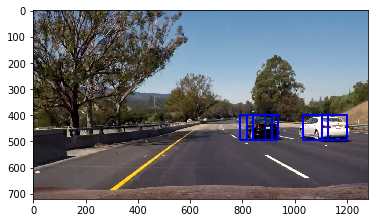

In [277]:
image=read_image('snap4.png')
hot=search_one(image,True)

## Heat mapping and labels

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def heat_map(img,windows,threshold=0):
    if (len(img.shape)==3):
        heatmap=np.zeros_like(img[:,:,0])
    else:
        heatmap=np.zeros_like(img)
    heatmap=add_heat(heatmap,windows)
    apply_threshold(heatmap,threshold)
    return heatmap

def determine_labels(heatmap):
    labels=label(heatmap)
    return labels[0],labels[1]

def draw_labels(img,labels,max):
    out=np.copy(img)
    for i in range(1,max+1):
        nonzero = (labels == i).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(out, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return out

# Optimization and video pipeline

## Optimized function to determine hot windows
This function searches in a specific region of an image for cars at a specific scale.

In [109]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart,xstop, scale, svc, X_scaler, color_space, spatial_size, hist_bins, 
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat,plot=False,all=False):
#def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    on_windows = []
    if (plot):
        draw_img = np.copy(img)
    else:
        draw_img=None
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    hog_img = convert_color(img_tosearch, color_space='YCrCb')
    img_tosearch=convert_color(img_tosearch,color_space)
    if scale != 1:
        imshape = img_tosearch.shape
        hog_img = cv2.resize(hog_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    
    ch1 = hog_img[:,:,0]
    ch2 = hog_img[:,:,1]
    ch3 = hog_img[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if (all or (test_prediction ==1)):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                ww=((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart))
                on_windows.append(ww)
                if (plot):
                    cv2.rectangle(draw_img,ww[0],ww[1],(0,0,255),6) 
                
    return draw_img,on_windows

def convert_color(img, color_space):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img) 
    return feature_image

## optimized function to search a single image for hot windows at various sizes
Also the sizes used for searching are hard coded

In [267]:
def search_one_fast(image,plot=False):
    all=False
    if (plot):
        out=np.copy(image)
    t=time.time()

    hot=[]
    if (False): #small
        (xstart,xstop,ystart,ystop,scale)=(400, 900,400,500,0.25)
        (out_img,hot_windows) = find_cars(image, ystart, ystop, xstart,xstop,scale, svc, X_scaler, color_space, spatial_size, hist_bins, 
                  orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat,plot,all)
        if (plot):
            out = draw_boxes(out, hot_windows, color=(0,0,255), thick=6)
        for i in range(len(hot_windows)):
            hot.append(hot_windows[i])
    
    if (True): #intermediate
        (xstart,xstop,ystart,ystop,scale)=(0, 1280,350,550,1)
        (out_img,hot_windows) = find_cars(image, ystart, ystop, xstart,xstop,scale, svc, X_scaler, color_space, spatial_size, hist_bins, 
                  orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat,plot,all)
        if (plot):
            out = draw_boxes(out, hot_windows, color=(0,0,255), thick=6)
        for i in range(len(hot_windows)):
            hot.append(hot_windows[i])
    if (True): #medium
        (xstart,xstop,ystart,ystop,scale)=(0, 1280,350,650,1.5)
        (out_img,hot_windows) = find_cars(image, ystart, ystop, xstart,xstop,scale, svc, X_scaler, color_space, spatial_size, hist_bins, 
                  orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat,plot,all)
        if (plot):
            out = draw_boxes(out, hot_windows, color=(0,255,0), thick=6)
        for i in range(len(hot_windows)):
            hot.append(hot_windows[i])

    if (True): #large
        (xstart,xstop,ystart,ystop,scale)=(48, 1280,350,700,3)
        (out_img,hot_windows) = find_cars(image, ystart, ystop, xstart,xstop,scale, svc, X_scaler, color_space, spatial_size, hist_bins, 
                  orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat,plot,all)
        if (plot):
            out = draw_boxes(out, hot_windows, color=(255,0,0), thick=6)
        for i in range(len(hot_windows)):
            hot.append(hot_windows[i])
    
    t2=time.time()
    if (plot):
        plt.imshow(out)
        plt.show()
        print("Processing time:",round(t2-t,2),"s")
        print("Number of detections: ",len(hot))



    return hot

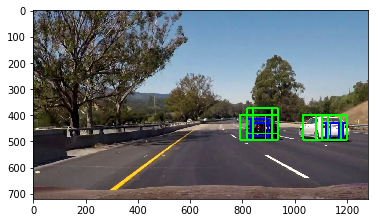

Processing time: 4.21 s
Number of detections:  14
Number of detections:  14


In [271]:
all=True
plot=True
image=read_image('snap4.png')

hot=search_one_fast(image,True)

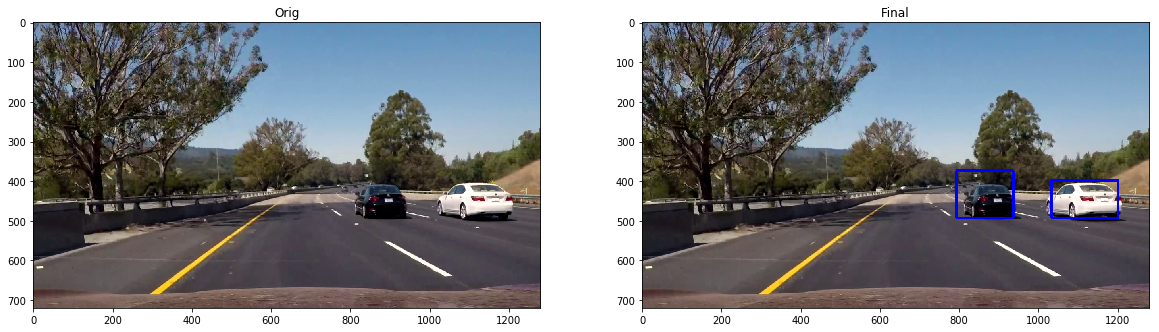

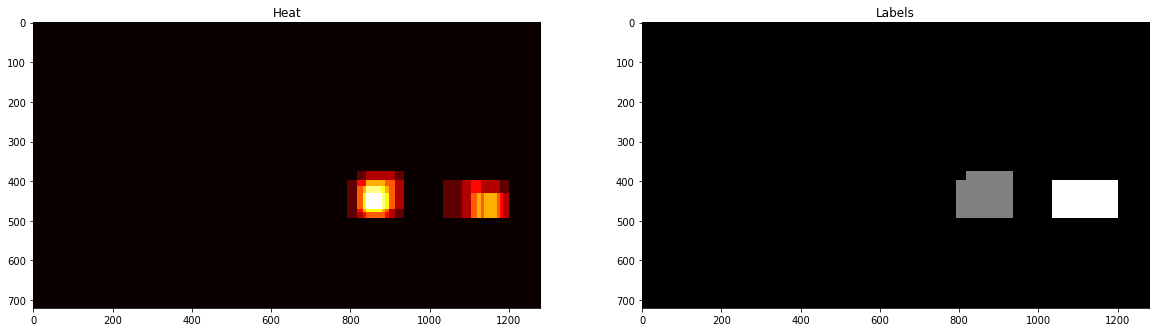

Cars found:  2


In [279]:
image=read_image('snap4.png')
hot_windows=search_one_fast(image)
heatmap=heat_map(image,hot_windows,0)
(labels,count)=determine_labels(heatmap)
labeled=draw_labels(image,labels,count)
plot_multi([image,labeled],['Orig','Final'])

plot_multi([heatmap,labels],['Heat','Labels'],['hot',True])

print("Cars found: ",count)

## Functions to save and restore the full state

In [73]:
import pickle

def save_state(fname):
    global svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins
    global color_space,hog_channel,spatial_feat,hist_feat,hog_feat
    
    vars={ "svc": svc, 
          "scaler": X_scaler,
          "orient":orient,
          "pix_per_cell":pix_per_cell,
          "cell_per_block":cell_per_block,
          "spatial_size":spatial_size,
          "hist_bins":hist_bins,
          "color_space":color_space,
          "hog_channel":hog_channel,
          "spatial_feat":spatial_feat,
          "hist_feat":hist_feat,
          "hog_feat":hog_feat
         }
    
    pickle.dump( vars, open( fname, "wb" ) )

def restore_state(fname):
    global svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins
    global color_space,hog_channel,spatial_feat,hist_feat,hog_feat
        
    dist_pickle = pickle.load( open(fname, "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    color_space=dist_pickle["color_space"]
    hog_channel=dist_pickle["hog_channel"]
    spatial_feat=dist_pickle["spatial_feat"]
    hist_feat=dist_pickle["hist_feat"]
    hog_feat=dist_pickle["hog_feat"]
    return dist_pickle

In [257]:
#save_state("nonlinear.p")

In [280]:
restore_state("nonlinear.p")

{'cell_per_block': 2,
 'color_space': 'HSV',
 'hist_bins': 16,
 'hist_feat': True,
 'hog_channel': 'ALL',
 'hog_feat': True,
 'orient': 11,
 'pix_per_cell': 16,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_feat': True,
 'spatial_size': (16, 16),
 'svc': GridSearchCV(cv=None, error_score='raise',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
        fit_params={}, iid=True, n_jobs=1,
        param_grid={'kernel': ['rbf'], 'C': [10], 'gamma': [0.0005]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring=None, verbose=0)}

## Pipeline definition

All functionality for feature extraction, image scanning, heat maaping and labeling is used from the previously defined function. In the pipeline, the optimized functions are used.

In the pipeline function itself, 2 additional options are build in:
1. roling average of the heatmaps. A number of consequetive heatmaps are summed, and threshold on the summed heatmap. This is controlled by the global parameters roling and roling_threshold
2. Analysing only part of the frames in the video. This is controlled by the global parameter ratio.

roling average is used to reduce false positives.
The frame sampling is used to speedup the processing during parameter tuning, while still going through the complete video.

In [313]:
def init_pipeline(shape):
    global rid,id,labels,heatmap,count,heatmaps,roling_threshold,roling,ratio
    id=0
    rid=0
    roling=5
    roling_threshold=round(1.2*roling)   
    heatmaps=np.zeros([roling,shape[0],shape[1]])
    ratio=2

#    roling=1
#    roling_threshold=0
#    ratio=25

    return 1

def pipeline(img):
    global hot_windows,heatmaps,rid,id,labels,heatmap,count,roling_threshold,roling,ratio
    image =(img * 255).astype(np.uint8)
    if (id==0):
        hot_windows=search_one_fast(img)
        heatmap=heat_map(image,hot_windows,0)
        heatmaps[rid]=heatmap
        rid=(rid+1)%roling
        heatmap=np.sum(heatmaps,axis=0)
        apply_threshold(heatmap,roling_threshold)
        (labels,count)=determine_labels(heatmap)

    id=((id+1)%ratio)
    labeled=draw_labels(img,labels,count)
    return labeled

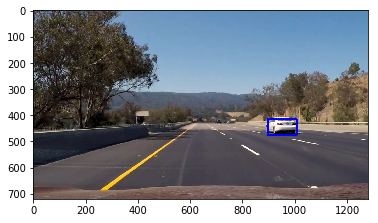

In [312]:
img=read_image('snap5.png')
init_pipeline(img.shape)
out=pipeline(img)
plt.imshow(out)
plt.show()


## Process a complete video file

In [ ]:
    
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip

init_pipeline(img.shape)
clip=VideoFileClip('project_video.mp4')
out=clip.fl_image(pipeline)
out.write_videofile('test_result.mp4',audio=False)